# Plots

This notebook containes the code used to create the plots presented in Mälicke (2021).

Please note, that these plots were used to showcase the plotting and analysis capabilities of [sciki-gstat](https://mmaelicke.github.io/scikit-gstat) and are **not** a geostatistical analysis at all.

**References**
Mälicke, M.: SciKit-GStat 1.0: A SciPy flavoured geostatistical variogram estimation toolbox written in Python, Geosci. Model Dev. Discuss. [preprint], https://doi.org/10.5194/gmd-2021-174, in review, 2021.

In [1]:
import numpy as np
import pandas as pd
import imageio
import json
import skgstat as skg
import gstools as gs
from plotly.offline import init_notebook_mode, iplot
import plotly.express as px
import plotly.graph_objects as go
import warnings
import matplotlib.pyplot as plt
from time import time
from scipy.optimize import curve_fit

plt.style.use('./paper.mplstyle')
warnings.filterwarnings('ignore')
print(skg.__version__)

/home/mirko/anaconda3/envs/py39/lib/python3.9/site-packages/xarray/backends/cfgrib_.py:27: UserWarning:

Failed to load cfgrib - most likely there is a problem accessing the ecCodes library. Try `import cfgrib` to get the full error message



1.0.1


In [2]:
# some global settings
N = 500
DPI = 150

## Load sample data

In [3]:
coordinates, values = skg.data.pancake(N=N, seed=42).get('sample')

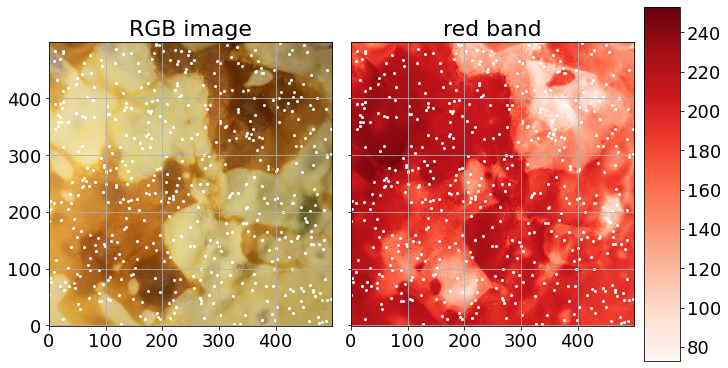

In [10]:
r = skg.data.pancake_field(band=0).get('sample')
g = skg.data.pancake_field(band=1).get('sample')
b = skg.data.pancake_field(band=2).get('sample')
img = np.stack((r,g,b), axis=2)

fig, ax = plt.subplots(1, 2, figsize=(10,5), sharex=True, sharey=True, constrained_layout=True)
ax[0].imshow(img, origin='lower')
m = ax[1].imshow(r, origin='lower', cmap='Reds')
ax[0].scatter(coordinates[:,0], coordinates[:,1], 4, color='w')
ax[1].scatter(coordinates[:,0], coordinates[:,1], 4, color='w')
ax[0].grid()
ax[1].grid()
ax[0].set_title('RGB image')
ax[1].set_title('red band')
plt.colorbar(m, fraction=0.0146, pad=0.014, ax=ax[1])
fig.savefig('./figures/pancake.pdf', dpi=DPI)

In [4]:
with open('./data/tereno_fendt/tereno.json', 'r') as js:
    data_obj = json.load(js)

coords = np.array(data_obj['coordinates'])
vals = np.array(data_obj['values'])
print(data_obj['description'])

Data derived from Fersch et al. (2020) https://doi.org/10.5194/essd-2020-48. Published under CC BY 4.0.
 It is  From the WSN product, the T_a in 20cm depth is extracted


## Variogram estimation

Demonstrate the variogram estimation using SciKit-GStat. With no further arguments supplied, the variogram uses a sensible guess for all needed arguments like the used model, amount of lag classes or semi-variance estimator. This default plot should give you some insight into the main spatial properties of the sample, but usually you want to adjust the arguments.

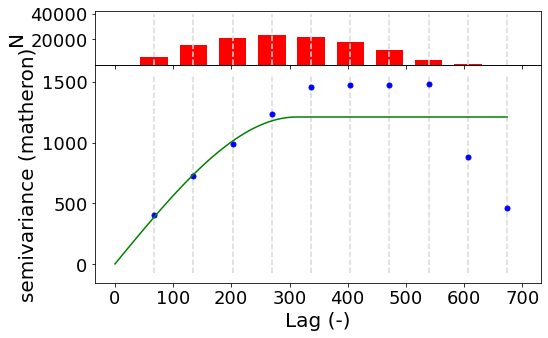

In [6]:
default = skg.Variogram(coordinates, values)
fig = default.plot()

#fig.savefig('./figures/default_variogram.pdf', dpi=DPI)

The search distance for point pairs was not restricted. You can see the drop in semi-variance for the last two classes. You can see that they are of very small sample size and thus we restrict the distance matrix to about 3/4 of the axis. It is also save to increase the amount of lag classes as many have sample sizes of >20,000.

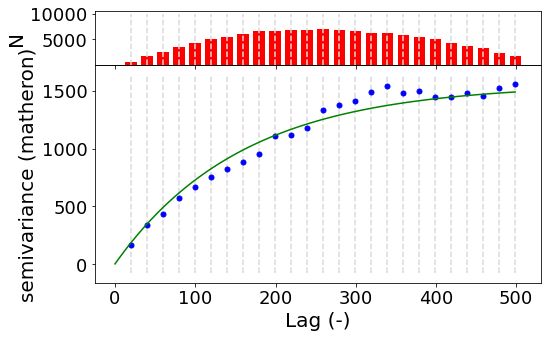

In [7]:
panvar = skg.Variogram(coordinates, values, maxlag=0.74, model='exponential', n_lags=25)
fig = panvar.plot()

fig.savefig('./figures/pancake_variogram.pdf', dpi=DPI)

Next, we create a scatter plot of the observations for each of the passed coordinate axes individually. This should help us to identify trends in the data.

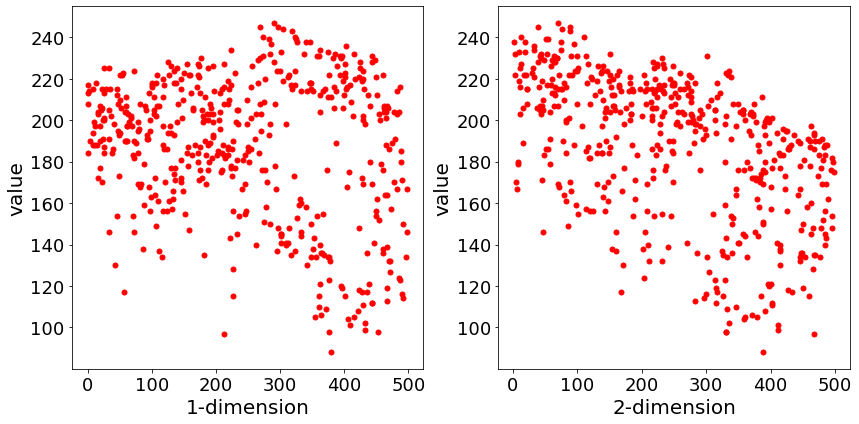

In [8]:
fig = panvar.location_trend()
fig.savefig('./figures/pancake_locationtrend.pdf', dpi=DPI)

You can see that the second dimension axis (y coordinates) show a moderate trend. The large value correlate with location on the y-axis. This violates the stationarity assumption underlying every geostatistical analysis. However, this trend is not very pronounced and the sample can still be considered to be independent of location. 

## Kriging

The best way to interpolate using a SciKit-GStat variogram is to export it to GSTools. That library has way more powerful kriging algorithms. SciKit-GStat only implements a ordinary kriging application, which is a bit slower that gstools.

If no arguments are supplied the interface function will return a ordinary kriging algorithm. If the field mean is supplied, simple kriging is used, if a trend function is given universal kriging is used and if an external drift term is given an external drift kriging algorithm will be instantiated.

In [ ]:
# use the interface to instantiate a gstools.Krige instance
ok = panvar.to_gs_krige()
print(ok)

# create the target grid
x = y = range(0, 500, 1)

# run
t1 = time()
field = ok.structured([x, y])
t2 = time()
print(f'Kriging took {np.round(t2 - t1, 2)} seconds')

Finally make a nice plot

In [ ]:
fig, _a = plt.subplots(1, 3, figsize=(15,4.5), sharex=True, sharey=True, constrained_layout=True)
axes = _a.flatten()
m1 = axes[0].imshow(r.T, vmin=50, vmax=250, cmap='terrain', origin='lower')
axes[1].imshow(field[0].T, vmin=50, vmax=250, cmap='terrain', origin='lower')
m2 = axes[2].imshow(field[1].T, cmap='RdYlGn_r', origin='lower')
axes[0].set_xticks([100,200,300,400,500])
axes[0].tick_params(labelrotation=45)
axes[1].tick_params(labelrotation=45)
axes[2].tick_params(labelrotation=45)
axes[0].set_title(f'Original')
axes[1].set_title(f'Oridnary Kriging')
axes[2].set_title('Error variance')
axes[0].plot(X, Y, 'w+', markersize=6, alpha=0.7)
axes[1].plot(X, Y, 'w+', markersize=6, alpha=0.7)
#axes[2].plot(X, Y, 'w+', markersize=6)
axes[0].grid(linewidth=2)
axes[1].grid(linewidth=2)
axes[2].grid(linewidth=2)
fig.colorbar(m1, ax=axes[0], shrink=0.99)
fig.colorbar(m2, ax=axes[2], shrink=0.99)

fig.savefig('./figures/pancake_kriging.pdf', dpi=DPI)

In [ ]:
print(f'Field  variance:   {np.var(r).round(1)}')
print(f'Result variance:   {np.var(field[0]).round(1)}')
print(f'Variance captured: {(np.var(field[0]) / np.var(r) * 100).round(1)}%')
print(f'Field  maxima:     {np.min(r)} - {np.max(r)}')
print(f'Result maxima:     {np.min(field[0]).round(0)} - {np.max(field[0]).round(0)}')
print(f'Observ.  maxima:   {np.min(values)} - {np.max(values)}')

## directional variogram

In [9]:
pan_east = skg.DirectionalVariogram(coordinates, values, azimuth=0, tolerance=45, maxlag=0.74, n_lags=25, model='exponential')
pan_north = skg.DirectionalVariogram(coordinates, values, azimuth=90, tolerance=45, maxlag=0.74, n_lags=25, model='exponential')

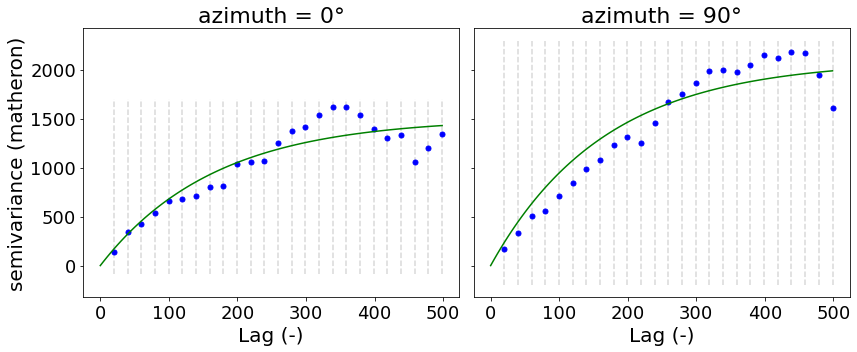

In [10]:
skg.plotting.backend('matplotlib')
fig, axes = plt.subplots(1, 2, figsize=(12, 5), sharey=True)

fig = pan_east.plot(axes=axes[0], show=False, hist=False)
fig = pan_north.plot(axes=axes[1], show=False, hist=False)
axes[0].set_title('azimuth = 0°')
axes[1].set_title('azimuth = 90°')
axes[1].set_ylabel(None)
plt.tight_layout()
fig.savefig('./figures/pancake_anisotropic.pdf', dpi=DPI)

In [128]:
d = pd.DataFrame([pan_east.describe(flat=True), pan_north.describe(flat=True)]).T
d.columns = ['azimuth = 0°', 'azimuth = 90°']
d

,azimuth = 0°,azimuth = 90°
model,stable,stable
estimator,matheron,matheron
dist_func,euclidean,euclidean
normalized_effective_range,171364.026441,214087.584096
normalized_sill,2284051.438736,4661014.373064
normalized_nugget,0,0
effective_range,343.644816,429.320493
sill,1411.941476,2136.417588
nugget,0,0
shape,1.377479,1.392596


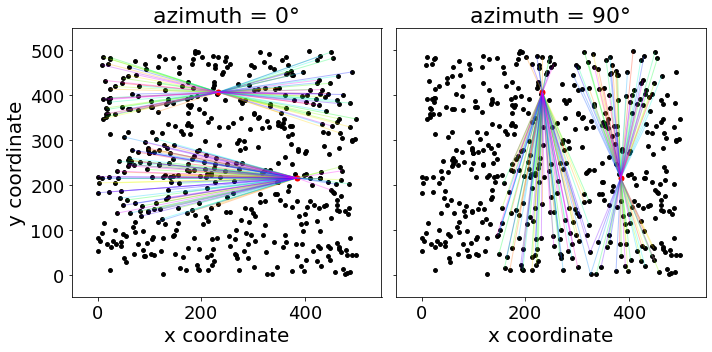

In [133]:
skg.plotting.backend('matplotlib')
fig, axes = plt.subplots(1, 2, figsize=(10, 5), sharex=True, sharey=True)

fig = pan_east.pair_field(ax=axes[0], points=[42, 170])
fig = pan_north.pair_field(ax=axes[1], points=[42, 170])

axes[0].set_title('azimuth = 0°')
axes[1].set_title('azimuth = 90°')
axes[0].set_ylabel('y coordinate')
axes[0].set_xlabel('x coordinate')
axes[1].set_xlabel('x coordinate')


plt.tight_layout()
fig.savefig('./figures/pancake_pair_field.pdf', dpi=DPI)

## Space-Time

In [5]:
STV = skg.SpaceTimeVariogram(coords, vals[:,::6], x_lags=20, t_lags=20, model='product-sum', maxlag=300)

In [6]:
STV.tbins

array([ 2.9,  5.8,  8.7, 11.6, 14.5, 17.4, 20.3, 23.2, 26.1, 29. , 31.9,
       34.8, 37.7, 40.6, 43.5, 46.4, 49.3, 52.2, 55.1, 58. ])

In [8]:
skg.plotting.backend('plotly')
fig = STV.contourf()
fig.update_layout(
    xaxis_title='space',
    yaxis_title='time',
    font=dict(size=14)
)

fig.write_image('./figures/stv_contour.pdf')
fig.show()

In [114]:
skg.plotting.backend('plotly')
fig = STV.plot(alpha=1)
fig.update_layout(
    template='plotly_white',
#    margin=dict(l=25, r=25),
    scene=dict(camera=dict(
        #eye=dict(x=-0.8979861027745052, y=-1.8543628019442224, z=0.07042412931253939),
        eye=dict(x=-2.2, y=-.7, z=0.4),
        center=dict(x=0, y=0, z=0),
    )),
    width=600,
    height=600
)
fig.show()
fig.write_image('./figures/st_3dplot.pdf')

## Distance-weighted fit

The last example illustrates the different possibilities to weight the lag classes in the fitting procedure. SciKit-GStat implements various different automatic functions to weight a lag class by distance. This example shows how large this impact can be.

In [115]:
cm = plt.get_cmap('gist_earth')
y = [1,7,9,6,14,10,13,9,11,12,14,12,15,13]
x = list(range(len(y)))

xi = np.linspace(0, len(y), 100)

# increase distance by 1 to avoid zeros
X = np.asarray([(_ + 0.) for _ in x])

s1 = X / np.max(X)
s2 = np.exp((s1 + 1)**2)
s3 = np.sqrt(s1)
s4 = np.power(s1, 2)
s = (s1, s2, s3, s4)
labels = ('linear', 'exp', 'sqrt', 'sq')

The plot below shows four different fits, all using exactly the same parameters except the way how the the distance is weighting the lag classes.

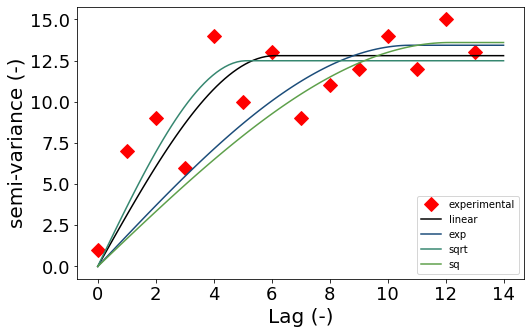

In [116]:
fig, ax = plt.subplots(1, 1, figsize=(8,5))
ax.plot(x, y, 'rD', label='experimental')
cofs = list()
for i in range(4):
    cof, cov = curve_fit(skg.models.spherical, x[:], y[:], sigma=1/s[i][:], p0=(8.,14.), bounds=(0,(14,14)))
    cofs.append(cof)
    yi = list(map(lambda x: skg.models.spherical(x, *cof), xi))
    ax.plot(xi, yi, linestyle='-', color=cm((i/6)), label=labels[i])
plt.legend(loc='lower right')
plt.gca().set_xlabel('Lag (-)')
plt.gca().set_ylabel('semi-variance (-)')
fig.savefig('./figures/distance_fit.pdf', dpi=DPI)

### Simulate fields

Finally, we use all four model functions from the plot above to simulate a random field. The creation of these fields will be seeded, so that same parameters will yield the same field. The only difference here is the difference in the model function due to the weighting function used.

In [40]:
models = []
for cof in cofs:
    model = gs.Spherical(dim=2, var=cof[1], len_scale=cof[0])
    models.append(model)

In [41]:
xx = yy = range(100)
srfs = []
fields = []

for model in models:
    srf = gs.SRF(model, seed=13062018)
    fields.append(srf.structured((xx, yy)))
    srfs.append(srf)

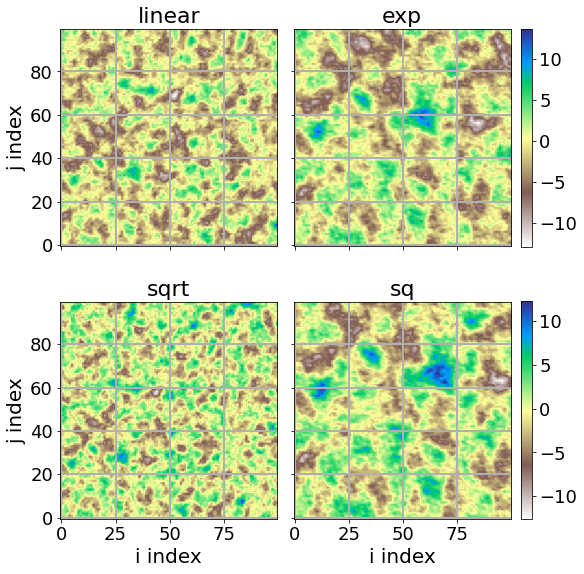

In [123]:
fig, _a = plt.subplots(2, 2, figsize=(8, 8), sharex=True, sharey=True, constrained_layout=True)
axes = _a.flatten()

for i, ax in enumerate(axes):
    m = ax.imshow(fields[i], origin='lower', cmap='terrain_r', interpolation=None)
    ax.set_title(labels[i])
    ax.grid(linewidth=2)
    if i in (1,3):
        plt.colorbar(m, ax=ax, shrink=0.85)
#plt.tight_layout()
axes[0].set_ylabel('j index')
axes[2].set_ylabel('j index')
axes[2].set_xlabel('i index')
axes[3].set_xlabel('i index')
fig.savefig('./figures/dist_fit_fields.pdf', dpi=DPI)

The differences are significant.